In [1]:
import os,glob
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,f1_score,precision_recall_fscore_support,precision_score,recall_score,roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.base import BaseEstimator, ClassifierMixin
from xgboost import XGBClassifier
from wordcloud import WordCloud
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import pickle
from sklearn.pipeline import Pipeline

In [2]:
filename = "appceleratorstudio.csv"
data = pd.read_csv(filename)
print(data.isnull().sum())

print(data.describe())
data = data.drop(['issuekey'], axis = 1)

data = data.dropna(how='any')

print(data.shape)
# print(data.describe())
print(data.groupby('storypoint').size())
data.head()

issuekey        0
title           0
description    43
storypoint      0
dtype: int64
        storypoint
count  2919.000000
mean      5.635492
std       3.327465
min       1.000000
25%       3.000000
50%       5.000000
75%       8.000000
max      40.000000
(2876, 3)
storypoint
1      148
2      112
3      571
5     1126
8      751
9        1
13     137
20      22
21       3
34       1
40       4
dtype: int64


,title,description,storypoint
0,Add CA against object literals in function inv...,{html}<div><p>The idea here is that if our met...,1
1,Update branding for Appcelerator plugin to App...,"{html}<div><p>At least fix feature icons, asso...",1
2,Create new JSON schema for SDK team,{html}<div><p>Create JSON schema containing pr...,1
3,Create Project References Property Page,{html}<div><p>Create property page for project...,1
4,New Desktop Project Wizard,{html}<div><p>Desktop (need to convert existin...,1


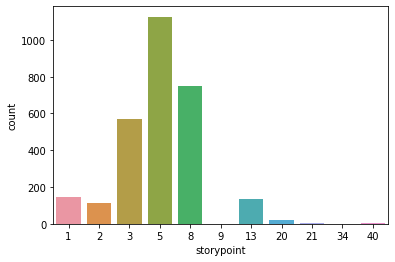

In [3]:
# data.head()
sns.countplot(x='storypoint', data=data)

In [4]:
data.loc[data.storypoint <= 2, 'storypoint'] = 0 #easy
data.loc[(data.storypoint > 2) & (data.storypoint <= 5), 'storypoint'] = 1 #average
data.loc[data.storypoint > 5, 'storypoint'] = 2 #complex



print(data.groupby('storypoint').size())

storypoint
0     260
1    1697
2     919
dtype: int64


In [5]:
data.describe()
data.head()

,title,description,storypoint
0,Add CA against object literals in function inv...,{html}<div><p>The idea here is that if our met...,0
1,Update branding for Appcelerator plugin to App...,"{html}<div><p>At least fix feature icons, asso...",0
2,Create new JSON schema for SDK team,{html}<div><p>Create JSON schema containing pr...,0
3,Create Project References Property Page,{html}<div><p>Create property page for project...,0
4,New Desktop Project Wizard,{html}<div><p>Desktop (need to convert existin...,0


In [6]:
data['titDescription'] = data[['title', 'description']].apply(lambda x: ' '.join(x.map(str)), axis=1)
data['titDescriptiontLEN'] = data['titDescription'].str.len()

data = data.drop(['title'], axis = 1)
data = data.drop(['description'], axis = 1)
print(data.shape)
data.head()

(2876, 3)


,storypoint,titDescription,titDescriptiontLEN
0,0,Add CA against object literals in function inv...,355
1,0,Update branding for Appcelerator plugin to App...,170
2,0,Create new JSON schema for SDK team {html}<div...,367
3,0,Create Project References Property Page {html}...,384
4,0,New Desktop Project Wizard {html}<div><p>Deskt...,530


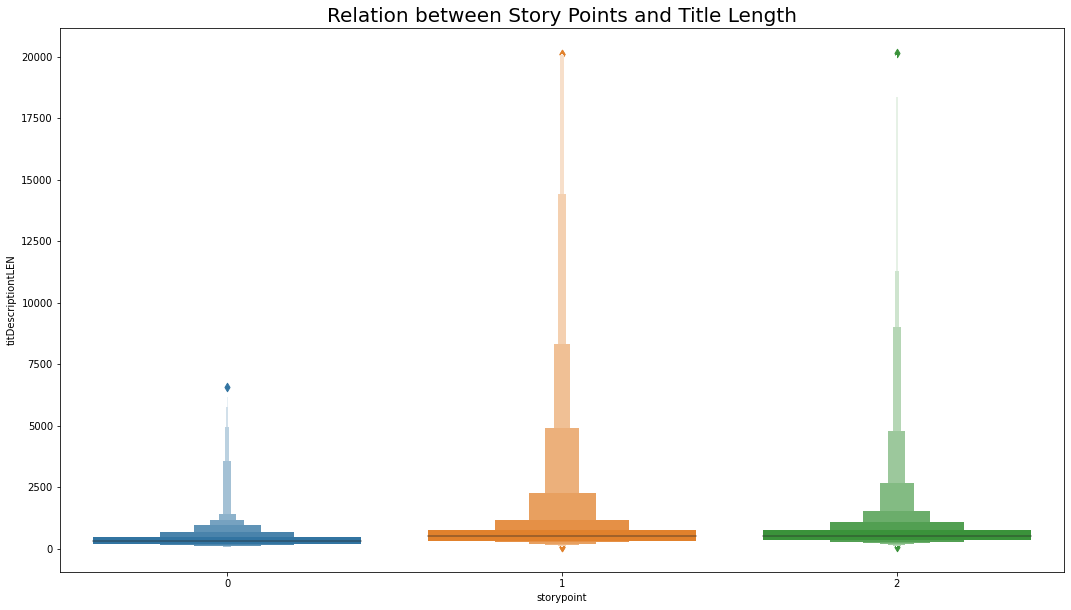

In [7]:
plt.rcParams['figure.figsize'] = (18, 10)
sns.boxenplot(x = data['storypoint'], y = data['titDescriptiontLEN'])
plt.title('Relation between Story Points and Title Length', fontsize = 20)
# plt.savefig('classes representation with sampling after new segmentation')
# plt.hist(data.storypoint, bins=20, alpha=0.6, color='y')
# plt.title("#Items per Point")
# plt.xlabel("Points")
# plt.ylabel("Count")
plt.show()

# plt.savefig('items per point')


In [8]:
# data = data.drop(['contextLEN'], axis = 1)

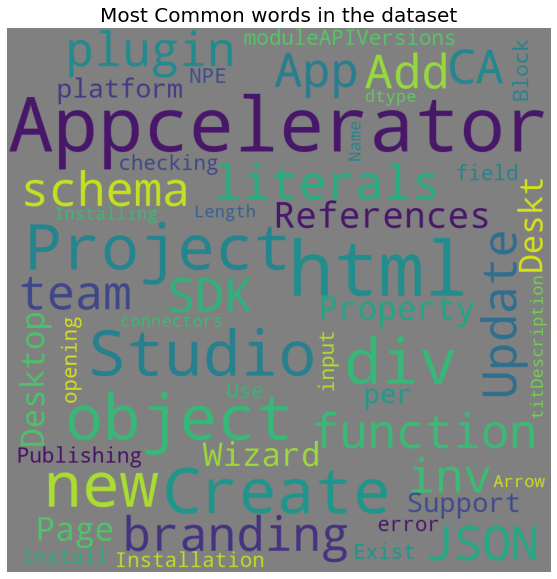

In [9]:
wordcloud = WordCloud(background_color = 'gray', width = 1000, height = 1000, max_words = 50).generate(str(data['titDescription']))
plt.rcParams['figure.figsize'] = (10, 10)
plt.title('Most Common words in the dataset', fontsize = 20)
plt.axis('off')
plt.imshow(wordcloud)
plt.savefig('common words')
plt.show()

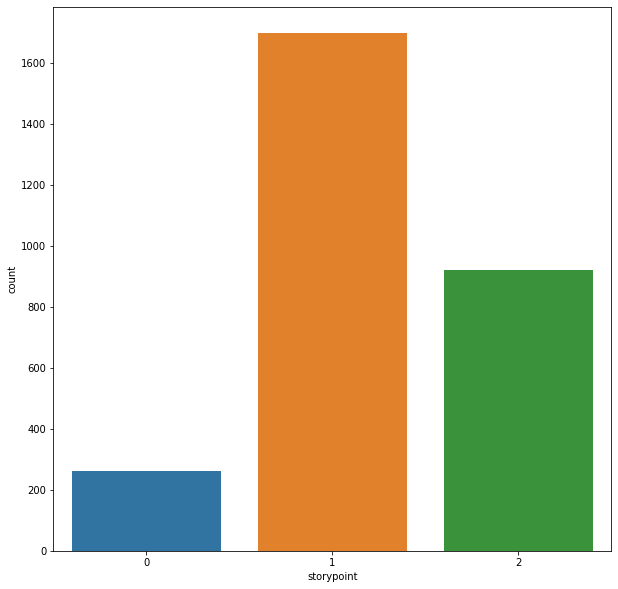

In [10]:
sns.countplot(x='storypoint', data=data)

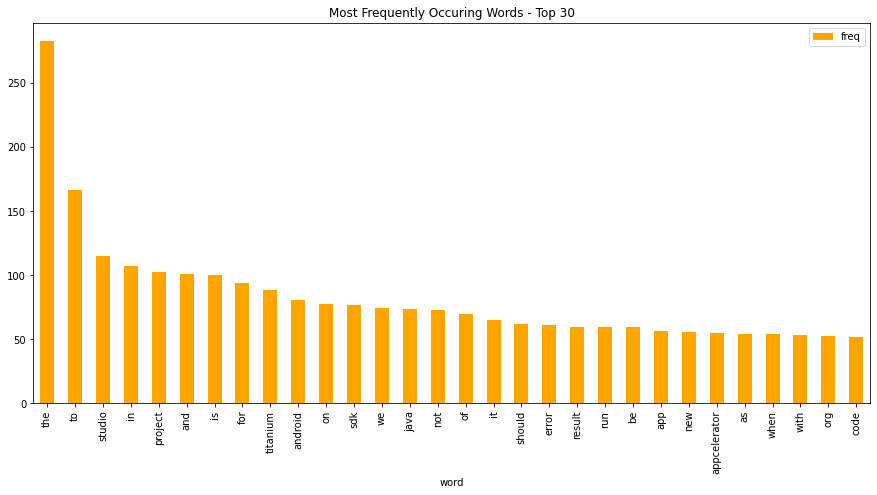

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
cv = CountVectorizer()
tfidf = TfidfVectorizer()
words = tfidf.fit_transform(data['titDescription'].values.astype('U'))
sum_words = words.sum(axis=0)
#
words_freq = [(word, sum_words[0, i]) for word, i in tfidf.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'orange')
plt.title("Most Frequently Occuring Words - Top 30")
plt.savefig('top common words')
plt.show()

In [12]:
# checking the most common words in the whole dataset
# import pickle
# corpusTitDescription = []
# n=data.shape[0]
# for i in range(0, n):

#   review = re.sub('[^a-zA-Z]', ' ', data['titDescription'].values.astype('U')[i])

#   review = review.lower()
#   review = review.split()
#   ps = PorterStemmer()
#   # stemming
#   review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]

#   # joining them back with space
#   review = ' '.join(review)

#   corpusTitDescription.append(review)
# with open("appcelerator2_pickle.txt", "wb") as fp:   #Pickling
#     pickle.dump(corpusTitDescription, fp)


In [13]:
with open("appcelerator2_pickle.txt", "rb") as fp:   # Unpickling
    corpusTitDescription = pickle.load(fp)
data = data.reset_index(drop=True)    
x = tfidf.fit_transform(corpusTitDescription).toarray()
y = data.iloc[:, 0]
# y = data.pop('storypoint')
# x = data

# print('x:',x)
# print('y:',y)
print('x_shape',x.shape)
print('y_shape',y.shape)

x_shape (2876, 7002)
y_shape (2876,)


In [14]:
# sc = StandardScaler()
# x = sc.fit_transform(x)

In [15]:
seed=50
models = []
models.append(('SVCLd', LinearSVC()))
models.append(('SVCLw', LinearSVC(class_weight='balanced',C=0.03)))
models.append(('LRD', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('xGBw', XGBClassifier(scale_pos_weight=99)))


# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
#     pipeline = Pipeline([('transformer', sc), ('estimator', model)])
    kfold = model_selection.StratifiedKFold(n_splits=10,random_state=seed,shuffle=True)
    accuracy = model_selection.cross_val_score(model, x, y, cv=kfold, scoring='accuracy')
    results.append(accuracy)
    names.append(name)
    
    msg_accuracy = "%s: %f (%f)" % (name, accuracy.mean(), accuracy.std())
    y_pred = model_selection.cross_val_predict(model, x, y, cv=kfold)
    cm = confusion_matrix(y, y_pred)
    cr = classification_report(y, y_pred)
    precision=precision_score(y, y_pred,average='weighted')
    recall=recall_score(y, y_pred,average='weighted')
    f_score=f1_score(y, y_pred,average='weighted')
    support=precision_recall_fscore_support(y,y_pred,average='weighted')
    print(name)
    print('Accuracy:',msg_accuracy)
    print('precision:',precision)
    print('recall:',recall)
    print('f1_score:',f_score)
    print('precision_recall_fscore_support:',support)
    print(cm)
    print(cr)
    
    print('================================================================')
    

SVCLd
Accuracy: SVCLd: 0.628328 (0.031623)
precision: 0.6140674460559611
recall: 0.6283031988873435
f1_score: 0.6099615855310638
precision_recall_fscore_support: (0.6140674460559611, 0.6283031988873435, 0.6099615855310638, None)
[[  54  150   56]
 [  31 1349  317]
 [  12  503  404]]
              precision    recall  f1-score   support

           0       0.56      0.21      0.30       260
           1       0.67      0.79      0.73      1697
           2       0.52      0.44      0.48       919

    accuracy                           0.63      2876
   macro avg       0.58      0.48      0.50      2876
weighted avg       0.61      0.63      0.61      2876

SVCLw
Accuracy: SVCLw: 0.611643 (0.033562)
precision: 0.6056977994292426
recall: 0.6116133518776078
f1_score: 0.6083479837030389
precision_recall_fscore_support: (0.6056977994292426, 0.6116133518776078, 0.6083479837030389, None)
[[  75  125   60]
 [ 101 1220  376]
 [  46  409  464]]
              precision    recall  f1-score   suppo

KeyboardInterrupt: 